AEMatter
====

**Revisiting Context Aggregation for Image Matting**

 * Paper: https://arxiv.org/pdf/2304.01171

![AEMatter Overview](../assets/aematter_overview.png)

```bash
git clone https://github.com/aipixel/AEMatter.git
```

## Download the model
 * AEMatter https://mega.nz/file/7N4AEKrS#L4h3Cm2qLMMbwBGm1lyGOmVDTXJwDMAi4BlBauqNHrI

 * Also, download swin model from huggingface

In [1]:
import torch
from transformers import AutoModel, AutoImageProcessor

# Load model and processor
model_name = "microsoft/swin-tiny-patch4-window7-224"
swin_model = AutoModel.from_pretrained(model_name)
processor = AutoImageProcessor.from_pretrained(model_name)

# Save model as .pth
torch.save(
    {"model": swin_model.state_dict()},
    "swin_tiny_patch4_window7_224.pth"
)
print("Model weights saved as swin_tiny_patch4_window7_224.pth")


/home/pyml/anaconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model weights saved as swin_tiny_patch4_window7_224.pth


In [2]:
import os
import sys

import cv2
from PIL import Image
import numpy as np
import torch

sys.path.append("AEMatter_repo")
import model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/pyml/anaconda3/envs/py311/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

matmodel = model.AEMatter()
matmodel.load_state_dict(
    torch.load('checkpoints/AEMFIX.ckpt', map_location='cpu'
)['model'])
matmodel=matmodel.to(device)
matmodel.eval();

/home/pyml/anaconda3/envs/py311/lib/python3.11/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [12]:
#rawimg=pimgs+file
image_path = "../samples/plants.jpg"
trimap_path = "plants_trimap.png"

rawimg=cv2.imread(image_path)
trimap=cv2.imread(trimap_path, cv2.IMREAD_GRAYSCALE)

def run_model(rawimg, trimap):
    trimap_nonp = trimap.copy()
    h, w, c = rawimg.shape
    nonph, nonpw, _ = rawimg.shape
    newh = (((h - 1) // 32) + 1) * 32
    neww = (((w - 1) // 32) + 1) * 32
    padh = newh - h
    padh1 = int(padh / 2)
    padh2 = padh - padh1
    padw = neww - w
    padw1 = int(padw / 2)
    padw2 = padw - padw1
    rawimg_pad = cv2.copyMakeBorder(
        rawimg, padh1, padh2, padw1, padw2, cv2.BORDER_REFLECT
    )
    trimap_pad = cv2.copyMakeBorder(
        trimap, padh1, padh2, padw1, padw2, cv2.BORDER_REFLECT
    )
    h_pad, w_pad, _ = rawimg_pad.shape
    tritemp = np.zeros([*trimap_pad.shape, 3], np.float32)
    tritemp[:, :, 0] = (trimap_pad == 0)
    tritemp[:, :, 1] = (trimap_pad == 128)
    tritemp[:, :, 2] = (trimap_pad == 255)
    tritempimgs = np.transpose(tritemp, (2, 0, 1))
    tritempimgs = tritempimgs[np.newaxis, :, :, :]
    img = np.transpose(rawimg_pad, (2, 0, 1))[np.newaxis, ::-1, :, :]
    img = np.array(img, np.float32)
    img = img / 255.
    img = torch.from_numpy(img).to(device)
    tritempimgs = torch.from_numpy(tritempimgs).to(device)


    with torch.no_grad():
        pred = matmodel(img, tritempimgs)
        pred = pred.detach().cpu().numpy()[0]
        pred = pred[:, padh1: padh1 + h, padw1: padw1 + w]
        preda = pred[0: 1, ]*255
        preda = np.transpose(preda,(1,2,0))
        preda = preda*(trimap_nonp[:, :, None] == 128)+(trimap_nonp[: ,: , None]==255) * 255
    preda = np.array(preda, np.uint8)

    return preda

predicted_alpha_matte = run_model(rawimg, trimap)

predicted_alpha_matte.shape

(1137, 1068, 1)

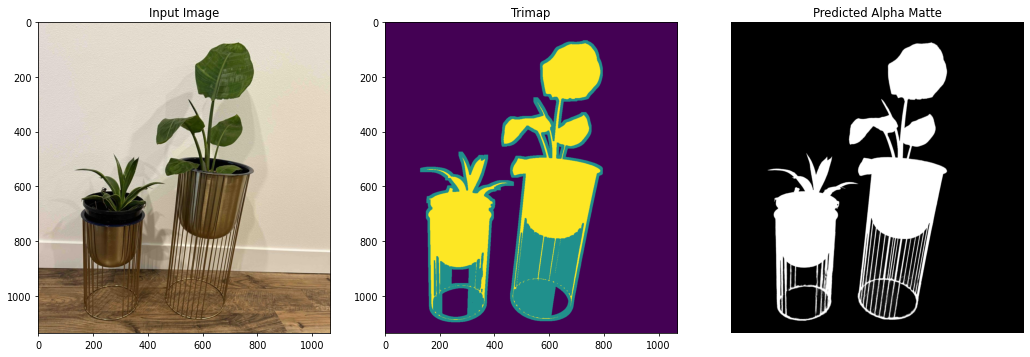

In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=70)
axes[0].set_title("Input Image")
axes[0].imshow(cv2.cvtColor(rawimg, cv2.COLOR_BGR2RGB))
axes[1].set_title("Trimap")
axes[1].imshow(trimap)
axes[2].set_title("Predicted Alpha Matte")
axes[2].axis('off')
axes[2].imshow(predicted_alpha_matte, cmap='gray')
plt.tight_layout()
plt.show()